In [1]:
import numpy as np 
import pandas as pd 
from glob import glob
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import ttest_ind


In [61]:
inceptionResNetV2_cm=np.array([[36,16],[55,127]])
efficientNetB3_cm=np.array([[37,15],[37,145]])
efficientNetB2_cm=np.array([[43,9],[43,139]])
y_test=np.ones([52])
y_test=np.concatenate([y_test,np.zeros([182])])

inceptionResNetV2_pred=np.zeros([len(y_test)])
numbers = np.random.choice(range(0, 52), 36, replace=False)
inceptionResNetV2_pred[numbers]=1
numbers = np.random.choice(range(52, len(y_test)), 55, replace=False)
inceptionResNetV2_pred[numbers]=1
efficientNetB2_pred=np.copy(inceptionResNetV2_pred)
ttp=np.where(efficientNetB2_pred[:52]==0)[0]
numbers = np.random.choice(range(0, len(ttp)), 1, replace=False)
efficientNetB2_pred[ttp[numbers]]=1
ffp=np.where(efficientNetB2_pred[52:]==1)[0]+52
numbers = np.random.choice(range(0, len(ffp)), 55-37, replace=False)
efficientNetB2_pred[ffp[numbers]]=0
efficientNetB3_pred=np.copy(inceptionResNetV2_pred)
ttp=np.where(efficientNetB3_pred[:52]==0)[0]
numbers = np.random.choice(range(0, len(ttp)), 43-36, replace=False)
efficientNetB3_pred[ttp[numbers]]=1
ffp=np.where(efficientNetB3_pred[52:]==1)[0]+52
numbers = np.random.choice(range(0, len(ffp)), 55-43, replace=False)
efficientNetB3_pred[ffp[numbers]]=0

In [94]:
import numpy as np
import pandas as pd
from scipy.stats import t, ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 가상의 예제 데이터 생성
data_model1 = inceptionResNetV2_pred
data_model2 = efficientNetB2_pred
data_model3 = efficientNetB3_pred

# 이진분류 모델 3개의 결과를 각각 저장
results_model1 = data_model1 > 0
results_model2 = data_model2 > 0
results_model3 = data_model3 > 0

true_labels = y_test

# 성능 지표 계산 함수
def calculate_performance_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_true, y_pred)
    return accuracy, sensitivity, specificity, f1

alpha_values = [0.2, 0.15, 0.1, 0.05, 0.025, 0.01, 0.005, 0.001]

# 결과를 저장할 DataFrame 생성
result_df = pd.DataFrame(columns=['Model', 'Metric', 'Value','Alpha', 'Confidence Interval', 'p-value', 'ANOVA with bonferroni collection p-value'])

# 각 모델에 대한 신뢰구간, p-value, ANOVA p-value 계산 및 DataFrame에 저장
for model, results in zip(['inceptionResNetV2', 'efficientNetB2', 'efficientNetB3'], [results_model1, results_model2, results_model3]):
    accuracy, sensitivity, specificity, f1 = calculate_performance_metrics(true_labels, results)

    # Calculate p-value using t-test
    t_statistic, p_value_ttest = ttest_ind(results, true_labels)

    # Perform ANOVA
    _, p_value_anova = f_oneway(results_model1, results_model2, results_model3)

    # Apply Bonferroni correction to ANOVA p-value
    _, p_value_anova_corrected, _, _ = multipletests([p_value_anova], method='bonferroni')

    for metric_name, metric_value in zip(['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'], [accuracy, sensitivity, specificity, f1]):
        for alpha in alpha_values:
            # Calculate standard error of the mean
            sem = np.std(results) / np.sqrt(len(results))

            # Adjust margin_of_error and confidence_interval based on the metric
            if metric_name == 'Accuracy':
                margin_of_error = t.ppf(1 - alpha / 2, len(results) - 1) * sem
            else:
                z_score = norm.ppf(1 - alpha / 2)
                margin_of_error = z_score * np.sqrt((metric_value * (1 - metric_value)) / len(results))

            confidence_interval = (metric_value - margin_of_error, metric_value + margin_of_error)

            # 결과를 DataFrame에 추가
            result_df = pd.concat([result_df, pd.DataFrame({
                'Model': [model],
                'Metric': [metric_name],
                'Value': [metric_value],
                'Alpha': [(1 - alpha) * 100],
                'Confidence Interval': [(confidence_interval[1] - confidence_interval[0])/2],
                'p-value': [p_value_ttest],
                'ANOVA with bonferroni collection p-value': [p_value_anova_corrected[0]]
            })])

# 결과 DataFrame 출력
print(result_df)
# 결과 DataFrame을 CSV 파일로 저장 (필요에 따라 주석 처리)
result_df.to_csv('model_comparison_results.csv', index=False)


/tmp/ipykernel_3012593/3726468130.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame({


                Model    Metric     Value  Alpha  Confidence Interval  \
0   inceptionResNetV2  Accuracy  0.696581   80.0             0.040958   
0   inceptionResNetV2  Accuracy  0.696581   85.0             0.046028   
0   inceptionResNetV2  Accuracy  0.696581   90.0             0.052629   
0   inceptionResNetV2  Accuracy  0.696581   95.0             0.062788   
0   inceptionResNetV2  Accuracy  0.696581   97.5             0.071895   
..                ...       ...       ...    ...                  ...   
0      efficientNetB3  F1 Score  0.623188   95.0             0.062089   
0      efficientNetB3  F1 Score  0.623188   97.5             0.071004   
0      efficientNetB3  F1 Score  0.623188   99.0             0.081598   
0      efficientNetB3  F1 Score  0.623188   99.5             0.088922   
0      efficientNetB3  F1 Score  0.623188   99.9             0.104239   

     p-value  ANOVA with bonferroni collection p-value  
0   0.000083                                  0.242462  
0   0.000

In [106]:
import pandas as pd
from docx import Document
from docx.shared import Pt
from docx.enum.table import WD_ALIGN_VERTICAL, WD_ALIGN_VERTICAL

# Read CSV data into a pandas DataFrame
df = pd.read_csv('model_comparison_results.csv')

# Exclude the 'Value' column
df = df.drop(columns=['Value'])

# Round the remaining values to four decimal places
df = df.round(4)

# Create a new Word document
doc = Document()

# Add a title to the document
doc.add_heading('Table Title', level=1)

# Create a table in the Word document
table = doc.add_table(rows=1, cols=len(df.columns))

# Set table style
table.style = 'Table Grid'

# Set column names as the header of the table
for col_num, col_name in enumerate(df.columns):
    cell = table.cell(0, col_num)
    cell.text = col_name
    cell.paragraphs[0].runs[0].font.size = Pt(10)
    cell.paragraphs[0].alignment = WD_ALIGN_VERTICAL.CENTER

# Populate the table with data
for row_num in range(len(df)):
    row_cells = table.add_row().cells
    for col_num, value in enumerate(df.iloc[row_num]):
        row_cells[col_num].text = str(value)
        row_cells[col_num].paragraphs[0].runs[0].font.size = Pt(10)
        row_cells[col_num].paragraphs[0].alignment = WD_ALIGN_VERTICAL.CENTER

# Save the Word document
doc.save('output_table.docx')


In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

auc=[0.767,0.821,0.800]
auc_ci=[[0.713,0.821],[0.763,0.879],[0.740,0.861]]
accuracy=[0.697,0.778,0.778]
accuracy_ci=[[0.635,0.759],[0.718,0.838],[0.716,0.840]]
sensitivity=[0.692,0.827,0.712]
sensitivity_ci=[[0.633,0.751],[0.769,0.885],[0.664,0.761]]
specificity=[0.698,0.764,0.797]
specificity_ci=[[0.639,0.757],[0.712,0.816],[0.743,0.851]]



Text(0, 0.5, 'Value')

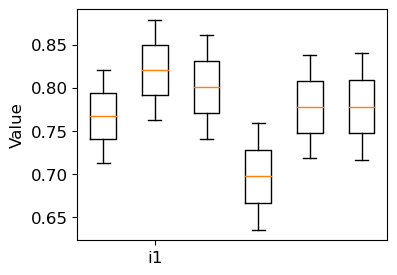

In [144]:
import matplotlib.pyplot as plt

# Data
models = ['Model 1', 'Model 2', 'Model 3']
auc = [0.767, 0.821, 0.800]
accuracy = [0.697, 0.778, 0.778]
sensitivity = [0.692, 0.827, 0.712]
specificity = [0.698, 0.764, 0.797]

# Confidence Intervals
auc_ci = [[0.713, 0.821], [0.763, 0.879], [0.740, 0.861]]
accuracy_ci = [[0.635, 0.759], [0.718, 0.838], [0.716, 0.840]]
sensitivity_ci = [[0.633, 0.751], [0.769, 0.885], [0.664, 0.761]]
specificity_ci = [[0.639, 0.757], [0.712, 0.816], [0.743, 0.851]]


# Boxplot 그리기
plt.boxplot([auc_ci[0], auc_ci[1], auc_ci[2],accuracy_ci[0], accuracy_ci[1], accuracy_ci[2]])


# X축 설정
plt.xticks([2],['i1'])

# Y축 설정
plt.ylabel('Value')

['inceptionResNetV2', 'efficientNetB2', 'efficientNetB3']

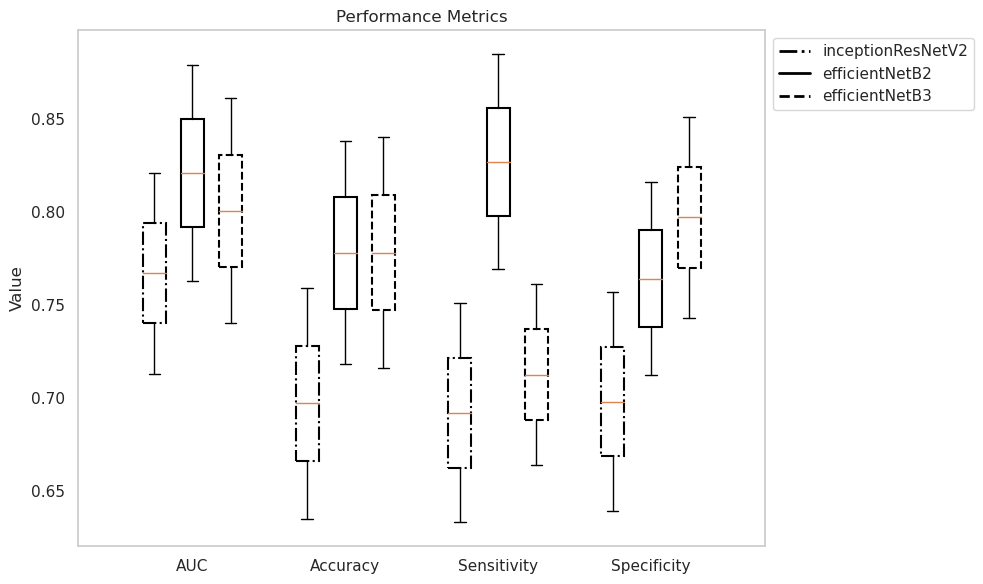

In [186]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

models = ['inceptionResNetV2', 'efficientNetB2', 'efficientNetB3']

# Confidence Intervals
auc_ci = [[0.713, 0.821], [0.763, 0.879], [0.740, 0.861]]
accuracy_ci = [[0.635, 0.759], [0.718, 0.838], [0.716, 0.840]]
sensitivity_ci = [[0.633, 0.751], [0.769, 0.885], [0.664, 0.761]]
specificity_ci = [[0.639, 0.757], [0.712, 0.816], [0.743, 0.851]]

# Prepare data for box plots
data = [auc_ci, accuracy_ci, sensitivity_ci, specificity_ci]
metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Specificity']

# Create a single box plot for all models
fig, ax = plt.subplots(figsize=(10, 6))
box_width = 0.15  # Adjusted box width
box_padding = 0.1  # Adjusted box padding

# Define line styles for each model
line_styles = ['-.', '-', '--']

# Plot box plots for each model
handles = []
for i, model in enumerate(models):
    positions = np.arange(len(metrics)) + (box_width + box_padding) * i
    boxes = ax.boxplot([metric[i] for metric in data], positions=positions, widths=box_width,
                       patch_artist=True)

    # Set box colors
    for box in boxes['boxes']:
        box.set_facecolor('white')

    # Set linestyle for box edges
    plt.setp(boxes['boxes'], linestyle=line_styles[i], linewidth=1.5)

    # Create a custom legend line with different styles
    line = Line2D([0], [0], color='black', linestyle=line_styles[i], linewidth=2)
    handles.append(line)

# Set labels and title
ax.set_ylabel('Value')
ax.set_title('Performance Metrics')
ax.set_xticks(np.arange(len(metrics)) + (len(models) - 1) * (box_width + box_padding) / 2)
ax.set_xticklabels(metrics)

# Remove grid lines
ax.grid(False)

# Add legend with custom lines outside the plot
ax.legend(handles, models, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


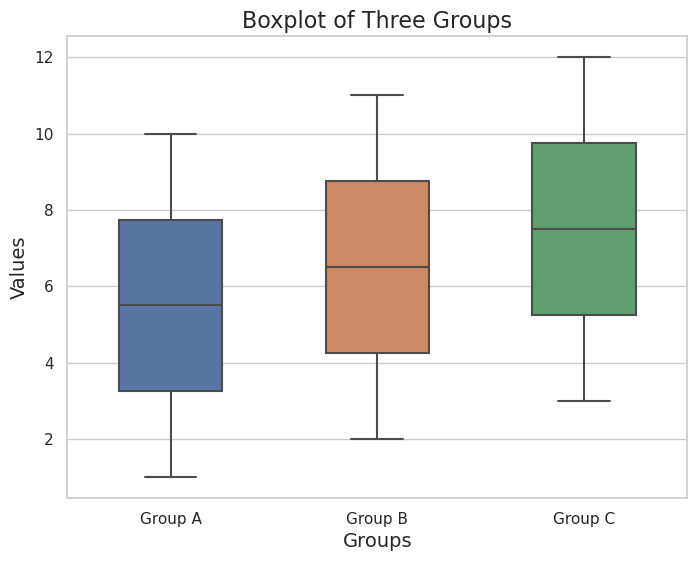

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터 생성
data = {
    'Group A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Group B': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'Group C': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
}

# 데이터프레임 생성
import pandas as pd
df = pd.DataFrame(data)

# boxplot 그리기
sns.set(style="whitegrid")  # 그리드 스타일 설정
plt.figure(figsize=(8, 6))  # 그림 크기 설정

# 세 개의 그룹을 묶어서 boxplot 그리기
sns.boxplot(data=df, width=0.5)

# 그래프 제목과 축 레이블 설정
plt.title('Boxplot of Three Groups', fontsize=16)
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Values', fontsize=14)

# 그래프 표시
plt.show()